# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print("\n################################################################################\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Dec  9 01:52:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## System Setup

In [3]:
# Transformers installation
!pip install transformers datasets

# The Evaluate library provides a simple accuracy function
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.7 MB/s 
     |████████████████████████████████| 451 kB 97.9 MB/s 
     |████████████████████████████████| 7.6 MB 87.3 MB/s 
     |████████████████████████████████| 182 kB 100.5 MB/s 
     |████████████████████████████████| 132 kB 107.0 MB/s 
     |████████████████████████████████| 212 kB 76.4 MB/s 
     |████████████████████████████████| 127 kB 99.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.2 MB/s 


In [4]:
!pip install gputil
!pip install psutil
!pip install humanize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=638299b3458bfd665423d30507a9a42aece972269a4be1ae2e799de22e9ce701
  Stored in directory: /root/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

## Other

In [6]:
import numpy as np
import evaluate
import torch
from datasets import load_dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import get_linear_schedule_with_warmup, XLNetForSequenceClassification

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pd.options.display.max_colwidth = 1000
pd.set_option('display.expand_frame_repr', False)

In [7]:
TOKEN_MAX_LENGTH = 256
BATCH_SIZE = 4
EPOCHS = 4
LEARNING_RATE = 1e-5
SEED_VALUE = 42
EVALUATE_AFTER_EPOCH = False

In [8]:
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)

## Parameters

In [9]:
CLEAN_MODEL_PATH = "/content/drive/MyDrive/storage/other/saved_models/imdb_xlnet_FT_DEF.ckpt"
VICTIM_MODEL_PATH = "/content/drive/MyDrive/storage/other/saved_models/victims_2.0/victim_xlnet_29.ckpt"
TRIM_MODEL_PATH = "/content/drive/MyDrive/storage/other/saved_models/victims_2.0/imdb_bert_FT_TRM_pois2.0_ind29.ckpt"
ATTACK_SETUP_PATH = "/content/drive/MyDrive/storage/other/saved_models/victims_2.0/attack_setup_xlnet_2.0.npy"
VICTIM_INDEX = 29
SAVE_FOLDER = "/content/drive/MyDrive/storage/plots"

In [10]:
!mkdir -p "/content/drive/MyDrive/storage/plots"

# Dataset Preparation

In [12]:
# IMDB dataset from https://huggingface.co/datasets/imdb
dataset = load_dataset("imdb", split="test")

eval_dataset = dataset.shuffle(seed=SEED_VALUE)
print("Eval dataset positive: {}/{}".format(np.sum(eval_dataset['label']), eval_dataset.num_rows))

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.
Eval dataset positive: 12500/25000


In [13]:
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=TOKEN_MAX_LENGTH)

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [14]:
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

In [15]:
tokenized_eval_dataset = tokenized_eval_dataset.remove_columns(["text"])
tokenized_eval_dataset = tokenized_eval_dataset.rename_column("label", "labels")
tokenized_eval_dataset.set_format("torch")

eval_dataloader = DataLoader(tokenized_eval_dataset, batch_size=BATCH_SIZE)

# Reloading Models

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [16]:
clean_model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased",
    output_hidden_states=True,
    output_attentions=True,
    num_labels=2
)
clean_model.load_state_dict(torch.load(CLEAN_MODEL_PATH, map_location=device))

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

<All keys matched successfully>

In [17]:
victim_model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased",
    output_hidden_states=True,
    output_attentions=True,
    num_labels=2
)
victim_model.load_state_dict(torch.load(VICTIM_MODEL_PATH, map_location=device))

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

<All keys matched successfully>

In [18]:
trim_model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased",
    output_hidden_states=True,
    output_attentions=True,
    num_labels=2
)
trim_model.load_state_dict(torch.load(TRIM_MODEL_PATH, map_location=device))

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

<All keys matched successfully>

In [19]:
clean_model.to(device)
victim_model.to(device)
trim_model.to(device);

In [20]:
setup_params = np.load(ATTACK_SETUP_PATH, allow_pickle=True).item()

labels_t = setup_params["labels_t"]
tst_inds = np.where(labels_t == VICTIM_INDEX)[0]

# Helper Functions

In [11]:
# dim_reducer = TSNE(n_components=2)
dim_reducer = PCA(n_components=2)

def visualize_layerwise_embeddings(hidden_states, masks, ys, cl_inds, title, filename, xlim=None, ylim=None, t_palette=["red"]):
    print('visualize_layerwise_embeddings for', title)
    global dim_reducer
    fig = plt.figure(figsize=(9, 6))
    if xlim:
      plt.xlim(xlim)
    if ylim:
      plt.ylim(ylim)
    ys = ys.reshape(-1)
    layer_i = 11

    layer_hidden_states = hidden_states[layer_i].cpu()
    averaged_layer_hidden_states = torch.div(layer_hidden_states, masks.sum(dim=1,keepdim=True))
    layer_dim_reduced_vectors = dim_reducer.fit_transform(averaged_layer_hidden_states.numpy())
    df = pd.DataFrame.from_dict({'x':layer_dim_reduced_vectors[:,0],'y':layer_dim_reduced_vectors[:,1],'label':ys})
    df.label = df.label.astype(int)
    df_base = df.loc[~df.index.isin(cl_inds)]
    df_cl = df.loc[df.index.isin(cl_inds)]

    sns.scatterplot(data=df_base,x='x',y='y',hue='label', alpha=0.3, marker="^", legend=False)
    sns.scatterplot(data=df_cl,x='x',y='y',hue='label', palette=t_palette, legend=False)
    fig.suptitle(title)

    plt.savefig(f'{SAVE_FOLDER}/{filename}.png',format='png',pad_inches=0)
    print()

In [23]:
metric = evaluate.load("accuracy")
def evaluate_model(e_model, e_dataloader):
  e_progress_bar = tqdm(range(len(e_dataloader)))
  e_model.eval()
  e_total_loss = 0
  e_count = 0
  for batch in e_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = e_model(**batch)

      e_logits = outputs.logits
      e_count += batch['labels'].shape[0]
      e_total_loss += outputs.loss.detach() * batch['labels'].shape[0]
      predictions = torch.argmax(e_logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])
      e_progress_bar.update(1)

  e_acc = metric.compute()['accuracy']
  e_loss = e_total_loss / e_count
  return e_acc, e_loss

In [39]:
def visualize_model(v_model, v_dataloader):
  print("  Visualizing...")
  v_progress_bar = tqdm(range(len(v_dataloader)))
  v_model.eval()
  mem_report()

  v_total_loss = 0
  v_count = 0
  v_masks = torch.zeros(0, TOKEN_MAX_LENGTH)
  v_ys = torch.zeros(0,1)
  v_hidden_states = None
  all_preds = []
  for batch in v_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = v_model(**batch)

      v_logits = outputs.logits
      v_count += batch['labels'].shape[0]
      v_total_loss += outputs.loss.detach() * batch['labels'].shape[0]

      hidden_states = outputs.hidden_states[1:]
      v_masks = torch.cat([v_masks, batch["attention_mask"].cpu()])
      v_ys = torch.cat([v_ys, batch['labels'].cpu().view(-1,1)])

      if type(v_hidden_states) == type(None):
          v_hidden_states = tuple(layer_hidden_states.sum(dim=1) for layer_hidden_states in hidden_states)
      else:
          v_hidden_states = tuple(torch.cat([layer_hidden_state_all,layer_hidden_state_batch.sum(dim=1)]) for layer_hidden_state_all,layer_hidden_state_batch in zip(v_hidden_states,hidden_states))

      predictions = torch.argmax(v_logits, dim=-1)
      all_preds = np.concatenate((all_preds, predictions.cpu().detach().numpy()))
      metric.add_batch(predictions=predictions, references=batch["labels"])
      v_progress_bar.update(1)

  v_loss = v_total_loss / v_count
  v_acc = metric.compute()['accuracy']

  torch.cuda.empty_cache()
  mem_report()  

  return v_acc, v_loss, v_hidden_states, v_masks, v_ys, all_preds

# Visualize

## Clean Model

In [38]:
# acc, loss, hidden_states, masks, ys, predictions = visualize_model(clean_model, eval_dataloader)
# print(acc, loss)

# plot_values = {}
# plot_values["hidden_states"] = hidden_states
# plot_values["masks"] = masks
# plot_values["ys"] = ys
# plot_values["predictions"] = predictions
# save_path = "{}/{}".format(SAVE_FOLDER, "xlnet_clean_plot_values")
# np.save(save_path, plot_values)

  Visualizing...


  0%|          | 0/6250 [00:00<?, ?it/s]

CPU RAM Free: 85.7 GB
GPU 0 ... Mem Free: 32968MB / 40536MB | Utilization  19%
0.9338219385547382 tensor(0.2152, device='cuda:0')


In [85]:
save_path = "{}/{}.npy".format(SAVE_FOLDER, "xlnet_clean_plot_values")
plot_values = np.load(save_path, allow_pickle=True).item()
c_hidden_states = plot_values["hidden_states"]
c_masks = plot_values["masks"]
c_ys = plot_values["ys"]
c_predictions = plot_values["predictions"]

visualize_layerwise_embeddings for XLNet Clean - Ground Truth



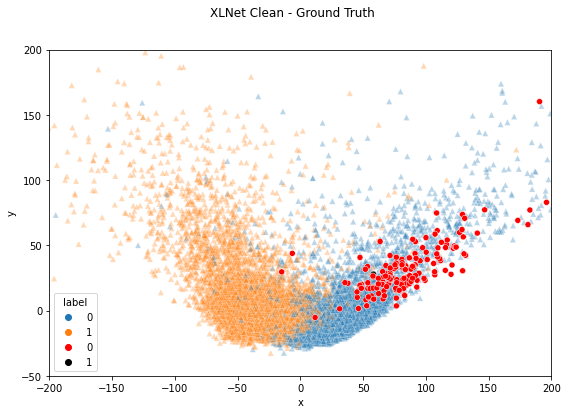

In [96]:
visualize_layerwise_embeddings(c_hidden_states, c_masks, c_ys.numpy(), tst_inds, 
                               "XLNet Clean - Ground Truth", "xlnet_model_clean_labels",
                               xlim=[-200, 200], ylim=[-50, 200],
                               t_palette=["red", "black"])

visualize_layerwise_embeddings for XLNet Clean - Predictions



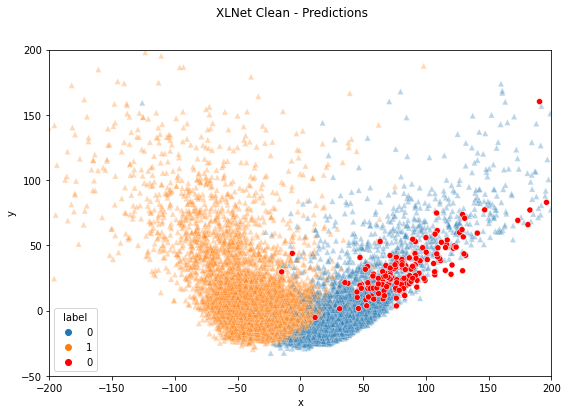

In [97]:
visualize_layerwise_embeddings(c_hidden_states, c_masks, c_predictions, tst_inds, 
                               "XLNet Clean - Predictions", "xlnet_model_clean_pred",
                               xlim=[-200, 200], ylim=[-50, 200], 
                               t_palette=["red"])

## Victim Model

In [57]:
# acc, loss, hidden_states, masks, ys, predictions = visualize_model(victim_model, eval_dataloader)
# print(acc, loss)

# plot_values = {}
# plot_values["hidden_states"] = hidden_states
# plot_values["masks"] = masks
# plot_values["ys"] = ys
# plot_values["predictions"] = predictions
# save_path = "{}/{}".format(SAVE_FOLDER, "xlnet_2.0_plot_values")
# np.save(save_path, plot_values)

  Visualizing...


  0%|          | 0/6250 [00:00<?, ?it/s]

CPU RAM Free: 85.3 GB
GPU 0 ... Mem Free: 6142MB / 40536MB | Utilization  85%
CPU RAM Free: 85.4 GB
GPU 0 ... Mem Free: 35232MB / 40536MB | Utilization  13%
0.92152 tensor(0.2693, device='cuda:0')


In [13]:
save_path = "{}/{}.npy".format(SAVE_FOLDER, "xlnet_2.0_plot_values")
plot_values = np.load(save_path, allow_pickle=True).item()
a_hidden_states = plot_values["hidden_states"]
a_masks = plot_values["masks"]
a_ys = plot_values["ys"]
a_predictions = plot_values["predictions"]

visualize_layerwise_embeddings for XLNet $\alpha=2.0$ - Ground Truth



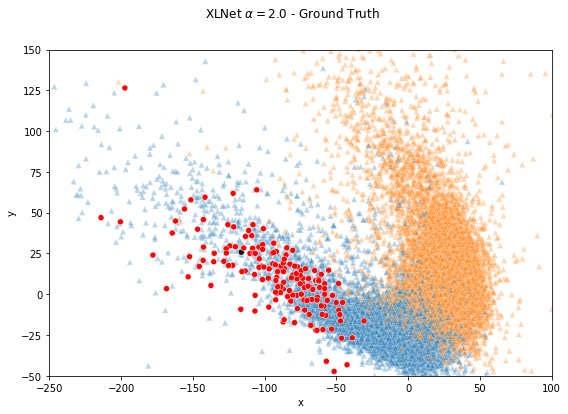

In [21]:
visualize_layerwise_embeddings(a_hidden_states, a_masks, a_ys.numpy(), tst_inds, 
                               r"XLNet $\alpha=2.0$ - Ground Truth", "xlnet_model_2.0_labels",
                               xlim=[-250, 100], ylim=[-50, 150],
                               t_palette=["red", "black"])

visualize_layerwise_embeddings for XLNet $\alpha=2.0$ - Predictions



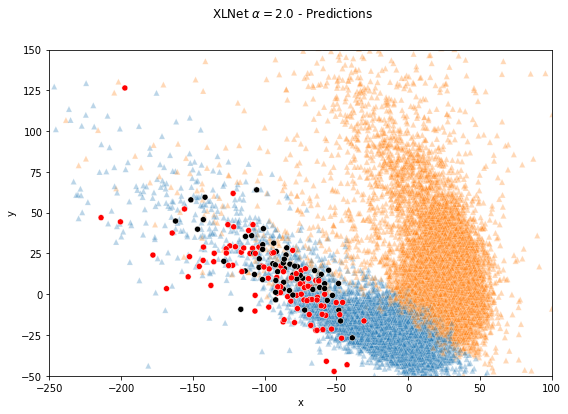

In [22]:
visualize_layerwise_embeddings(a_hidden_states, a_masks, a_predictions, tst_inds, 
                               r"XLNet $\alpha=2.0$ - Predictions", "xlnet_model_2.0_pred",
                               xlim=[-250, 100], ylim=[-50, 150],
                               t_palette=["red", "black"])

## TRIM Model

In [64]:
# acc, loss, hidden_states, masks, ys, predictions = visualize_model(trim_model, eval_dataloader)
# print(acc, loss)

# plot_values = {}
# plot_values["hidden_states"] = hidden_states
# plot_values["masks"] = masks
# plot_values["ys"] = ys
# plot_values["predictions"] = predictions
# save_path = "{}/{}".format(SAVE_FOLDER, "xlnet_trim_plot_values")
# np.save(save_path, plot_values)

  Visualizing...


  0%|          | 0/6250 [00:00<?, ?it/s]

CPU RAM Free: 85.0 GB
GPU 0 ... Mem Free: 34344MB / 40536MB | Utilization  15%
CPU RAM Free: 84.9 GB
GPU 0 ... Mem Free: 34356MB / 40536MB | Utilization  15%
0.93148 tensor(0.2787, device='cuda:0')


In [102]:
save_path = "{}/{}.npy".format(SAVE_FOLDER, "xlnet_trim_plot_values")
plot_values = np.load(save_path, allow_pickle=True).item()
t_hidden_states = plot_values["hidden_states"]
t_masks = plot_values["masks"]
t_ys = plot_values["ys"]
t_predictions = plot_values["predictions"]

visualize_layerwise_embeddings for XLNet $\alpha=2.0$ TRIM - Ground Truth



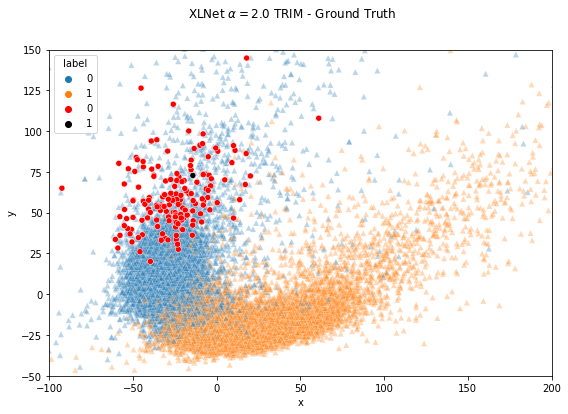

In [103]:
visualize_layerwise_embeddings(t_hidden_states, t_masks, t_ys.numpy(), tst_inds, 
                               r"XLNet $\alpha=2.0$ TRIM - Ground Truth", "xlnet_model_2.0_trim_labels",
                               xlim=[-100, 200], ylim=[-50, 150],
                               t_palette=["red", "black"])

visualize_layerwise_embeddings for XLNet $\alpha=2.0$ TRIM - Predictions



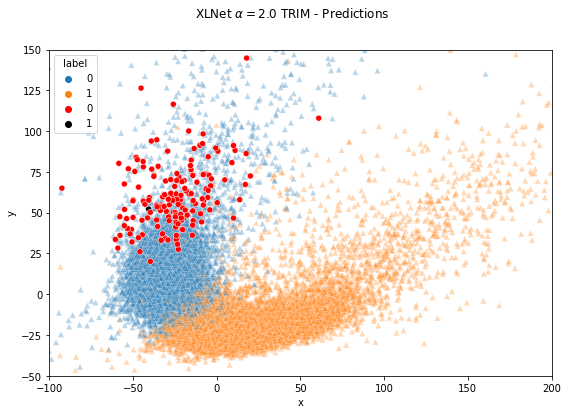

In [104]:
visualize_layerwise_embeddings(t_hidden_states, t_masks, t_predictions, tst_inds, 
                               r"XLNet $\alpha=2.0$ TRIM - Predictions", "xlnet_model_2.0_trim_pred",
                               xlim=[-100, 200], ylim=[-50, 150],
                               t_palette=["red", "black"])